In [1]:
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import keras
import cv2
%matplotlib inline
#import kmeans
from sklearn.cluster import KMeans
#important metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
data = []
label = []
path = "F:\\internship\\weld bead\\"
c = 0
d = 0
IMG_SIZE = 32
for file in os.listdir(path):
    img=cv2.imread(path+file)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img=img.astype('float32')
    if file[:56]=='bead':
        if c==500: continue
        c+=1
        label.append("good")
    else:
        if d==500: continue
        d+=1
        label.append("bad")
    data.append(img)
data = np.array(data)

In [3]:
data_label = []
for i in label:
    if i=="good_bead": data_label.append(0)
    else: data_label.append(1)
data_label = np.array(data_label)

In [4]:
data = data/255.0
reshaped_data = data.reshape(len(data),-1)

In [5]:
reshaped_data

array([[0.23921569, 0.25490198, 0.25882354, ..., 0.3137255 , 0.3137255 ,
        0.3137255 ],
       [0.32941177, 0.32941177, 0.33333334, ..., 0.0627451 , 0.07450981,
        0.10588235],
       [0.35686275, 0.45882353, 0.64705884, ..., 0.5529412 , 0.6862745 ,
        0.77254903],
       ...,
       [0.21568628, 0.23137255, 0.23529412, ..., 0.5803922 , 0.5686275 ,
        0.54901963],
       [0.9254902 , 0.9019608 , 0.88235295, ..., 0.3137255 , 0.26666668,
        0.23137255],
       [0.89411765, 0.9098039 , 0.8901961 , ..., 0.16078432, 0.16862746,
        0.2       ]], dtype=float32)

##Standard K means

In [6]:
kmeans = KMeans(n_clusters=4, random_state=50)

In [7]:
clusters = kmeans.fit_predict(reshaped_data)
kmeans.cluster_centers_.shape

(4, 3072)

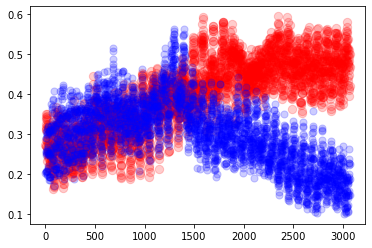

In [8]:
x_data = [i for i in range(3072)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2,s=70)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2,s=50)

In [9]:
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num 
    return reference_label
# Mapping predictions to original labels
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.random(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

In [10]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)
print(accuracy_score(predicted_labels,data_label))

1.0


# Elbow Method

In [11]:
sse = []
list_k = [2,16,64,100,256]
for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)
    reference_labels = get_reference_dict(clusters,data_label)
    predicted_labels = get_labels(clusters,reference_labels)
    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,data_label))
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Accuracy for k = 2:  1.0
Accuracy for k = 16:  1.0
Accuracy for k = 64:  1.0


ValueError: n_samples=66 should be >= n_clusters=100.

# Another

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import cv2
# Fit K-Means
kmeans_1 = KMeans(n_clusters=4,random_state= 10)
# Use fit_predict to cluster the dataset
cluster_df = reshaped_data
#cv2.imread("F:\\internship\\weld bead\\5.jpg")
predictions = kmeans_1.fit_predict(cluster_df)
# Calculate cluster validation metrics
score_kemans_s = silhouette_score(cluster_df, kmeans_1.labels_, metric='euclidean')
score_kemans_c = calinski_harabasz_score(cluster_df, kmeans_1.labels_)
score_kemans_d = davies_bouldin_score(cluster_df, predictions)
print('Silhouette Score: %.4f' % score_kemans_s)
print('Calinski Harabasz Score: %.4f' % score_kemans_c)
print('Davies Bouldin Score: %.4f' % score_kemans_d)

Silhouette Score: 0.1095
Calinski Harabasz Score: 7.7597
Davies Bouldin Score: 1.9114


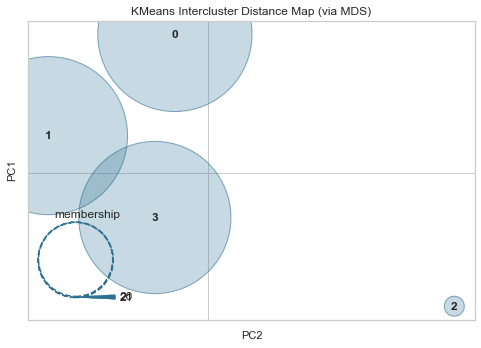

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [17]:
# Inter cluster distance map
from yellowbrick.cluster import InterclusterDistance
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(kmeans_1)
visualizer.fit(cluster_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


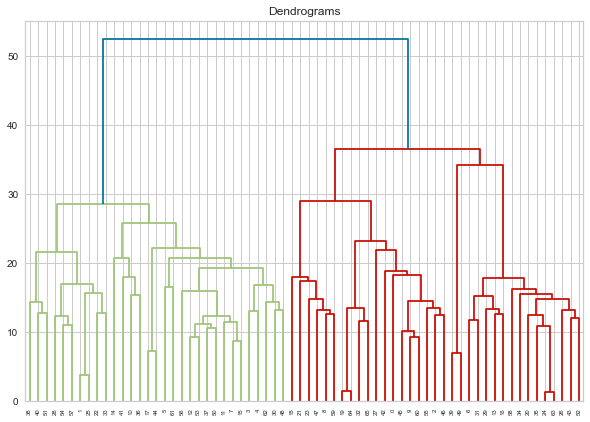

In [18]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(cluster_df, method='ward'))


In [19]:
# Agglomerative clustering
from numpy import unique
from numpy import where
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot
# define the model
model = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat = model.fit(cluster_df)
yhat_2 = model.fit_predict(cluster_df)
# retrieve unique clusters
clusters = unique(yhat)
# Calculate cluster validation metrics
score_AGclustering_s = silhouette_score(cluster_df, yhat.labels_, metric='euclidean')
score_AGclustering_c = calinski_harabasz_score(cluster_df, yhat.labels_)
score_AGclustering_d = davies_bouldin_score(cluster_df, yhat_2)
print('Silhouette Score: %.4f' % score_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
print('Davies Bouldin Score: %.4f' % score_AGclustering_d)

Silhouette Score: 0.0885
Calinski Harabasz Score: 7.3319
Davies Bouldin Score: 1.8836


# DBSCAN

In [21]:
pip install kneed


  Using cached kneed-0.7.0-py2.py3-none-any.whl (9.4 kB)



15.910185


<Figure size 360x360 with 0 Axes>

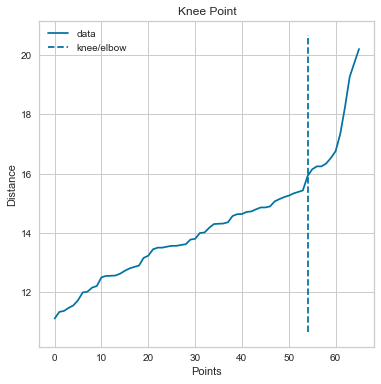

In [22]:
# parameter tuning for eps
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(cluster_df)
distances, indices = neighbors.kneighbors(cluster_df)
distances = np.sort(distances[:,10], axis=0)
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])


In [23]:
# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
# define dataset
# define the model
model = DBSCAN(eps=1.9335816413107338, min_samples= 18)
# rule of thumb for min_samples: 2*len(cluster_df.columns)
# fit model and predict clusters
yhat = model.fit_predict(cluster_df)
# retrieve unique clusters
clusters = unique(yhat)
# Calculate cluster validation metrics
score_dbsacn_s = silhouette_score(cluster_df, yhat, metric='euclidean')
score_dbsacn_c = calinski_harabasz_score(cluster_df, yhat)
score_dbsacn_d = davies_bouldin_score(cluster_df, yhat)
print('Silhouette Score: %.4f' % score_dbsacn_s)
print('Calinski Harabasz Score: %.4f' % score_dbsacn_c)
print('Davies Bouldin Score: %.4f' % score_dbsacn_d)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

# GMM

In [24]:
# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define the model
model = GaussianMixture(n_components= 26,covariance_type= "full", random_state = 10)
# fit the model
model.fit(cluster_df)
# assign a cluster to each example
yhat = model.predict(cluster_df)
# retrieve unique clusters
clusters = unique(yhat)
# Calculate cluster validation score
score_dbsacn_s = silhouette_score(cluster_df, yhat, metric='euclidean')
score_dbsacn_c = calinski_harabasz_score(cluster_df, yhat)
score_dbsacn_d = davies_bouldin_score(cluster_df, yhat)
print('Silhouette Score: %.4f' % score_dbsacn_s)
print('Calinski Harabasz Score: %.4f' % score_dbsacn_c)
print('Davies Bouldin Score: %.4f' % score_dbsacn_d)

Silhouette Score: 0.0758
Calinski Harabasz Score: 3.4604
Davies Bouldin Score: 1.1146


In [ ]:
##transfer learning

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
import keras

In [ ]:
from keras_applications.resnet import ResNet50

In [ ]:
from keras.applications.resnet50 import ResNet50

In [ ]:
model =   keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))

In [ ]:
def extract_vector(data_holder):

    resnet_feature_list = []

    for im in data_holder:

        im = image.img_to_array(im) 

        img = preprocess_input(np.expand_dims(im.copy(), axis=0))

        resnet_feature = model.predict(img)

        resnet_feature_np = np.array(resnet_feature)

        resnet_feature_list.append(resnet_feature_np.flatten())